<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_cbam_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#cbam & transformer 이론 보충

## CBAM  (Convolutional Block Attention Module)
-> CNN의 성능 향상을 목적으로 설계 됨

특징
 - 채널 어텐션 : 어떤 특성(채널)이 중요한지 학습
 - 공간 어텐션 : 어떤 공간적 위치가 중요한지 학습

 동작 방식

 입력 → 채널 어텐션 → 공간 어텐션 → 출력

(참고) https://ffighting.net/deep-learning-paper-review/vision-model/cbam/

-> SENet과 BAM의 한계점을 개선
* SENet의 한계
  - 채널 어텐션만 고려
  - 글로벌 평균 폴링 의존
  - 단일 차원 어텐션
- BAM의 한계
  - 병렬처리
  - 상호작용 부족
  - 복잡한 구조



## Transformer

핵심구조
- 인코더와 디코더 구조
- 셀프 어텐션
- 포지셔널 인코딩

개념

(참고) https://www.ibm.com/kr-ko/think/topics/transformer-model


# 이슈!!
## 그래프는 과적합이 난거 같은데 왜? 정확도가 좋음??
왜일까...
- 데이터 불균형
- 데이터 누수
- 모델 복잡도 => 강력한 후보

### 시도해볼 엑션
- 레이어 줄이기
- 뉴런 줄이기
- 드롭 아웃 비증 늘리기
- 규제
- 조기 종료 적용하기

### 시도 1. 레이어랑 뉴런 줄임
(11/03 12:55)
테스트 손실: 0.3172 테스트 정확도: 0.8962

- 결과 :과적합이 더 크게 줄어서 현실적인 결과가 나옴
- 개선 점 : 정확도가 불안정.... 글고 초기 에포크에서 손실 높음

### 시도 2. 학습률이랑 배치 크기 조정, 조기 종료 적용
(11/04 01:07) 테스트 손실: 0.4622 테스트 정확도: 0.8945

- 결과 : 과적합 해결됨. 에포크 10이후 정확도 안정적

### 질문
=> 손실은 늘었는데 왜 좋아짐??

클로드가 이야기 하길...

손실 ↑ = 모델이 더 "겸손"해짐 (확신도가 낮아짐)
정확도 ≈ = 여전히 올바른 클래스를 잘 맞춤

 손실이 높아진 것은 모델이 더 겸손해진 것입니다.

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Multiply

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report


# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Layer, Embedding, Activation, Multiply, Concatenate, Reshape, Lambda
)
from tensorflow.keras.models import Model

In [32]:
from google.colab import drive
drive.mount('/content/drive')

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

TRAIN = "train/"
TEST = "test/"
DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# X 데이터 로드 함수
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ')
                row_clean = row_clean.strip()
                serie = row_clean.split(' ')
                serie_array = np.array(serie, dtype=np.float32)
                series_list.append(serie_array)

        X_signals.append(series_list)

    X_signals = np.array(X_signals)
    return np.transpose(X_signals, (1, 2, 0))

# y 레이블 로드 함수
def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return np.array(labels, dtype=np.int32) - 1  # 0부터 시작하도록

# X 데이터 로드
X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# y 레이블 로드
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("="*60)
print("데이터 로딩 완료")
print("="*60)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\n첫 5개 레이블: {y_train[:5]}")

데이터 로딩 완료
X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
y_train shape: (7352,)
y_test shape: (2947,)

첫 5개 레이블: [4 4 4 4 4]


- X_train/X_test: 센서 신호 데이터 (3차원 배열)
- y_train/y_test: 활동 레이블 (1차원 배열)

## CBAM & Transformer

1. CNN 특징 추출 단계

Conv2D + BatchNorm: 공간적 패턴과 지역적 특징을 추출
CBAM: 중요한 채널과 공간 위치에 어텐션을 집중시켜 특징의 품질 향상

2. 차원 변환 단계

Reshape: 2D 특징맵 (height, width, channels)을 1D 시퀀스 (sequence_length, features)로 변환
Dense: Transformer 모델 차원과 맞추기 위한 선형 변환

3. Transformer 처리 단계

Self-Attention: 시퀀스 내 모든 위치 간의 관계를 학습하여 장거리 의존성 포착
Feed-Forward: 각 위치에서 독립적으로 비선형 변환 수행
잔차 연결 + 정규화: 그래디언트 소실 문제 해결 및 학습 안정화

4. 분류 단계

GlobalAveragePooling1D: 가변 길이 시퀀스를 고정 크기 벡터로 변환
Dense + Softmax: 최종 클래스 확률 출력

주요 특징
하이브리드 구조의 장점:

CNN: 지역적 공간 패턴 효과적 학습
CBAM: 중요한 특징에 선택적 집중
Transformer: 전역적 시간적 의존성 학습

In [34]:
# Transformer Encoder Layer
class TransformerEncoderLayer(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Combined CBAM-Transformer Model
def create_cbam_transformer_model(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, transformer_layers=1, dropout_rate=0.4):
    inputs = Input(shape=input_shape)

    # Initial CNN layers - Reduced filters
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(inputs) # Reduced from 64
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x) # Reduced from 64
    x = BatchNormalization()(x)

    # Apply CBAM block (Assuming cbam_block is defined elsewhere, e.g., in cell 7wvGHsqJM373)
    # If cbam_block is not defined in an executable cell, you might need to include its definition here as well
    x = cbam_block(x, ratio=8)

    # Further CNN layers - Reduced filters
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x) # Reduced from 128
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x) # Reduced from 128
    x = BatchNormalization()(x)

    # Prepare for Transformer: Reshape and potentially reduce dimensions
    # Assuming the output of CNN is (batch, height, width, channels)
    # We need to flatten height and width to get (batch, sequence_length, features)
    # where sequence_length = height * width and features = channels
    _, height, width, channels = x.shape
    sequence_length = height * width
    x = Reshape((sequence_length, channels))(x) # Reshape for Transformer

    # Add a Dense layer to match d_model if channels != d_model
    if channels != d_model:
        x = Dense(d_model, activation='relu')(x)

    # Apply Transformer Encoder layers
    for _ in range(transformer_layers):
        x = TransformerEncoderLayer(d_model, num_heads, ff_dim, dropout_rate)(x, training=True) # Pass training argument

    # Global Average Pooling after Transformer
    x = GlobalAveragePooling1D()(x) # Pool over the sequence length dimension

    # Classifier
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [35]:
# CBAM (Convolutional Block Attention Module) 구현
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras import backend as K

def channel_attention(input_feature, ratio=8):
    """
    채널 어텐션 모듈
    - 각 채널의 중요도를 학습하여 중요한 채널에 더 많은 가중치 부여
    """
    channel = input_feature.shape[-1]  # 채널 수 확인

    # Global Average Pooling과 Global Max Pooling을 통한 특징 압축
    avg_pool = GlobalAveragePooling2D()(input_feature)  # 평균 풀링
    max_pool = GlobalMaxPooling2D()(input_feature)      # 최대 풀링

    # MLP를 통한 채널 중요도 학습 (공유 가중치)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = Reshape((1, 1, channel))(max_pool)

    # 첫 번째 Dense 레이어 (차원 축소)
    avg_pool = Dense(channel // ratio, activation='relu', use_bias=True)(avg_pool)
    max_pool = Dense(channel // ratio, activation='relu', use_bias=True)(max_pool)

    # 두 번째 Dense 레이어 (원래 차원으로 복원)
    avg_pool = Dense(channel, use_bias=True)(avg_pool)
    max_pool = Dense(channel, use_bias=True)(max_pool)

    # 두 경로의 결과를 합치고 시그모이드로 어텐션 가중치 생성
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # 원본 특징과 어텐션 가중치를 곱하여 채널 어텐션 적용
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    """
    공간 어텐션 모듈
    - 각 공간 위치의 중요도를 학습하여 중요한 위치에 더 많은 가중치 부여
    """
    kernel_size = 7  # 합성곱 커널 크기

    # 채널 차원에 대해 평균과 최대값 계산
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)  # 채널별 평균
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)   # 채널별 최대값

    # 두 특징맵을 채널 차원으로 연결
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    # 합성곱으로 공간 어텐션 맵 생성
    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1,
                         padding='same', use_bias=False)(concat)
    cbam_feature = Activation('sigmoid')(cbam_feature)  # 시그모이드로 0-1 사이 값 생성

    # 원본 특징과 공간 어텐션 가중치를 곱하여 공간 어텐션 적용
    return multiply([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    """
    CBAM 블록: 채널 어텐션과 공간 어텐션을 순차적으로 적용

    Args:
        cbam_feature: 입력 특징맵
        ratio: 채널 어텐션에서 사용할 차원 축소 비율

    Returns:
        어텐션이 적용된 특징맵
    """
    # 1단계: 채널 어텐션 적용
    cbam_feature = channel_attention(cbam_feature, ratio)

    # 2단계: 공간 어텐션 적용
    cbam_feature = spatial_attention(cbam_feature)

    return cbam_feature

print("CBAM 블록이 성공적으로 정의되었습니다!")
print("이제 create_cbam_transformer_model 함수를 사용할 수 있습니다.")

CBAM 블록이 성공적으로 정의되었습니다!
이제 create_cbam_transformer_model 함수를 사용할 수 있습니다.


1. 데이터 전처리

HAR 데이터를 Conv2D 레이어에 맞는 형태로 변환
(samples, time_steps, features) → (samples, time_steps, features, 1)

2. 모델 생성 및 컴파일

CBAM-Transformer 하이브리드 모델 생성
Adam 최적화기와 sparse_categorical_crossentropy 손실 함수로 컴파일

3. 학습 설정

조기 종료: 과적합 방지
학습률 감소: 학습 성능 향상

4. 모델 학습

50 에포크, 배치 크기 64로 학습
20% 검증 데이터로 성능 모니터링

5. 성능 평가

테스트 정확도 측정
학습 곡선 시각화
분류 리포트와 혼동 행렬로 상세 성능 분석

Reshaped X_train shape for training: (7352, 128, 9, 1)
Reshaped X_test shape for evaluation: (2947, 128, 9, 1)
Input shape used for Conv2D layers in model: (128, 9, 1)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 9, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 9,    │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 9,    │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 9,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 9,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1, 1, 32)  │          0 │ dense_32[0][0],   │
│                     │                   │            │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1, 1, 32)  │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 128, 9,    │          0 │ batch_normalizat… │
│ (Multiply)          │ 32)               │            │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 128, 9, 1) │          0 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 128, 9, 1) │          0 │ multiply_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 9, 2) │          0 │ lambda_8[0][0], 

 Total params: 150,032 (586.06 KB)

 Trainable params: 149,648 (584.56 KB)

 Non-trainable params: 384 (1.50 KB)


Starting model training...
Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 48s 642ms/step - accuracy: 0.6239 - loss: 0.9351 - val_accuracy: 0.1992 - val_loss: 5.7601 - learning_rate: 5.0000e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 364ms/step - accuracy: 0.9247 - loss: 0.2180 - val_accuracy: 0.1992 - val_loss: 6.9074 - learning_rate: 5.0000e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.9431 - loss: 0.1479 - val_accuracy: 0.1992 - val_loss: 7.0407 - learning_rate: 5.0000e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.9637 - loss: 0.1038 - val_accuracy: 0.1992 - val_loss: 6.7385 - learning_rate: 5.0000e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 366ms/step - accuracy: 0.9638 - loss: 0.0920 - val_accuracy: 0.2135 - val_loss: 6.4936 - learning_rate: 5.0000e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 365ms/step - accuracy: 0.9653 - loss: 0.0814 - val_accuracy: 0.1557 - val_loss: 6.4682 - learning_rate: 5.0000e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━

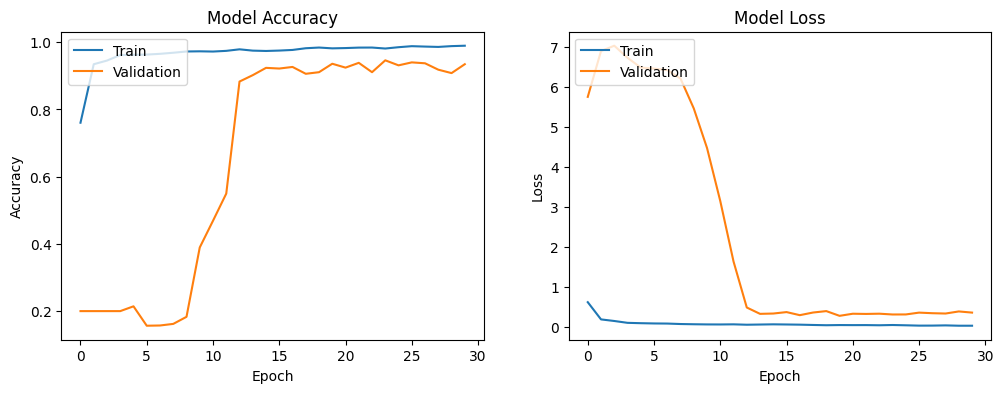


Generating Classification Report and Confusion Matrix...
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step
Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.87      0.92      0.90       496
  WALKING_UPSTAIRS       0.91      0.84      0.87       471
WALKING_DOWNSTAIRS       0.88      0.92      0.90       420
           SITTING       0.86      0.82      0.84       491
          STANDING       0.86      0.86      0.86       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



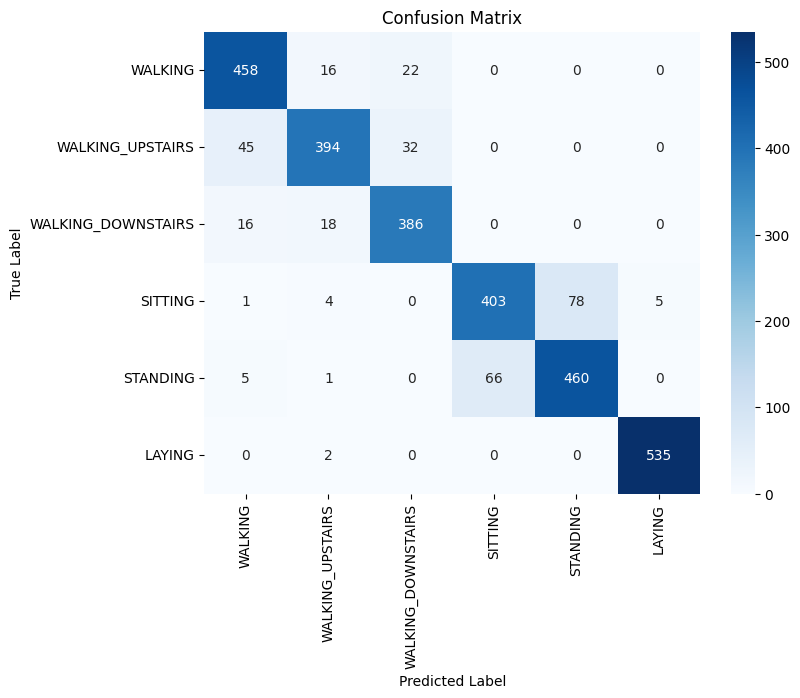

In [36]:
# Define input shape and number of classes based on your data
# Assuming X_train and LABELS are already loaded and defined
input_shape = X_train.shape[1:] # (128, 9) - need to adjust this for Conv2D input
num_classes = len(LABELS) # 6

# For Conv2D, input shape should be (height, width, channels).
# Our current data X_train is (samples, time_steps, features) -> (7352, 128, 9)
# We can treat time_steps as height, and features as width or vice-versa, or reshape.
# A common approach is to reshape the (time_steps, features) into (time_steps, features, 1) for Conv2D
input_shape_conv2d = (X_train.shape[1], X_train.shape[2], 1)

# Reshape the input data for Conv2D if not already done
# This is necessary for the Conv2D layers in the combined model
if len(X_train.shape) == 3: # Check if it's not already reshaped
    X_train_reshaped = np.expand_dims(X_train, axis=-1)
    X_test_reshaped = np.expand_dims(X_test, axis=-1)
elif len(X_train.shape) == 4 and X_train.shape[-1] == 1: # Check if it's already reshaped correctly
    X_train_reshaped = X_train
    X_test_reshaped = X_test
else:
    # Handle unexpected shape or add a reshape that fits your Conv2D input
    # For this case, assuming (samples, time_steps, features) -> (samples, time_steps, features, 1)
    print("Warning: X_train has an unexpected shape. Attempting reshape.")
    X_train_reshaped = np.expand_dims(X_train, axis=-1)
    X_test_reshaped = np.expand_dims(X_test, axis=-1)


print(f"Reshaped X_train shape for training: {X_train_reshaped.shape}")
print(f"Reshaped X_test shape for evaluation: {X_test_reshaped.shape}")
print(f"Input shape used for Conv2D layers in model: {input_shape_conv2d}")


# Create an instance of the combined model
# Assuming create_cbam_transformer_model is defined in a previous cell (e.g., QmmILdYxQxIq)
combined_model = create_cbam_transformer_model(
    input_shape=input_shape_conv2d,
    num_classes=num_classes,
    d_model=64, # Dimension for Transformer
    num_heads=4,
    ff_dim=128,
    transformer_layers=1,
    dropout_rate=0.4
)

# Compile the model
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate
combined_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

combined_model.summary()

# Train the model
epochs = 50
batch_size = 128  # Adjusted batch size

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

print("\nStarting model training...")
history = combined_model.fit(
    X_train_reshaped,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stopping, reduce_lr]
)

print("\nTraining finished.")



In [37]:
# 테스트 셋에서 모델 평가
print("\n테스트 셋에서 모델을 평가합니다...")
loss, accuracy = combined_model.evaluate(X_test_reshaped, y_test)
print(f"테스트 손실: {loss:.4f}")
print(f"테스트 정확도: {accuracy:.4f}")



테스트 셋에서 모델을 평가합니다...
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8664 - loss: 0.5636
테스트 손실: 0.4622
테스트 정확도: 0.8945


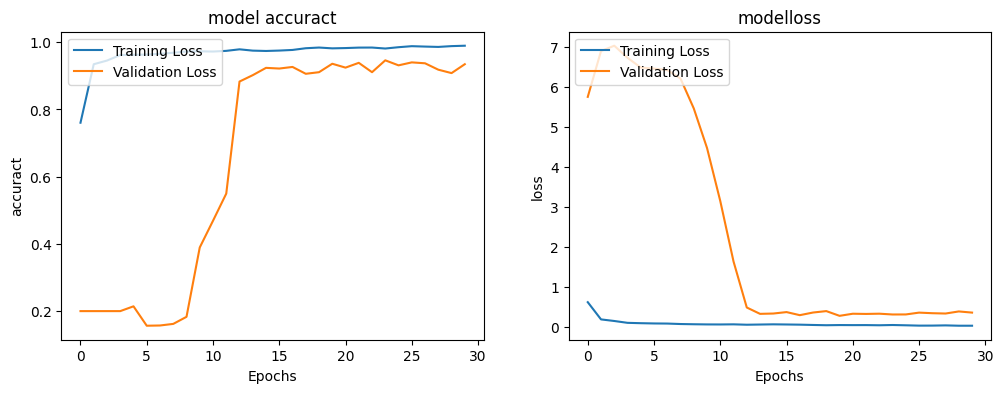

In [38]:

# 학습 히스토리 플롯
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])      # 학습 정확도
plt.plot(history.history['val_accuracy'])  # 검증 정확도
plt.title('model accuract')
plt.ylabel('accuract')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])          # 학습 손실
plt.plot(history.history['val_loss'])      # 검증 손실
plt.title('modelloss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')

plt.show()  # 그래프 출력


In [39]:

# 분류 리포트와 혼동 행렬 생성
print("\n분류 리포트와 혼동 행렬을 생성합니다...")
y_pred_probs = combined_model.predict(X_test_reshaped)  # 테스트 데이터에 대한 예측 확률
y_pred = np.argmax(y_pred_probs, axis=1)               # 가장 높은 확률의 클래스를 예측값으로 선택

print("분류 리포트:")
print(classification_report(y_test, y_pred, target_names=LABELS))  # 정밀도, 재현율, F1-score 등 상세 성능 지표



분류 리포트와 혼동 행렬을 생성합니다...
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
분류 리포트:
                    precision    recall  f1-score   support

           WALKING       0.87      0.92      0.90       496
  WALKING_UPSTAIRS       0.91      0.84      0.87       471
WALKING_DOWNSTAIRS       0.88      0.92      0.90       420
           SITTING       0.86      0.82      0.84       491
          STANDING       0.86      0.86      0.86       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



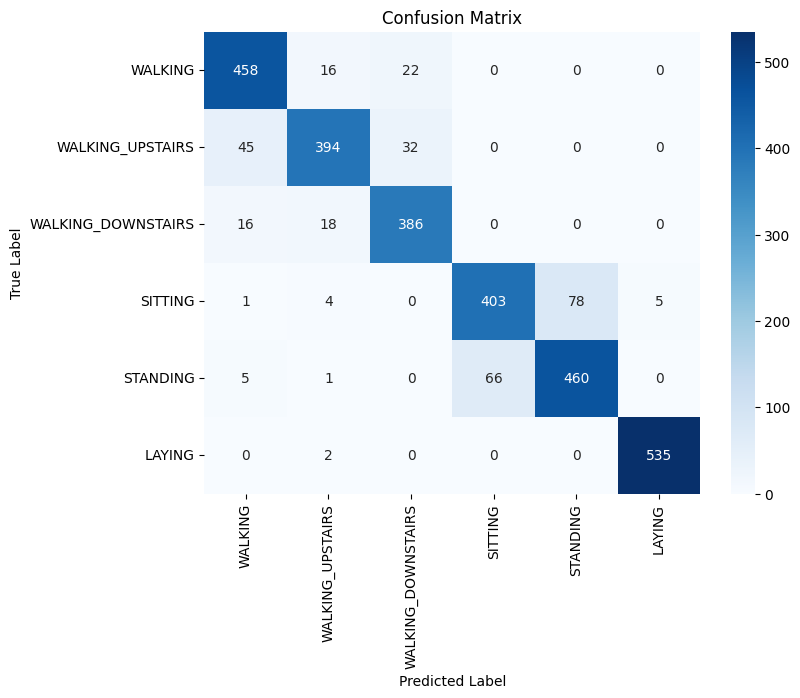

In [41]:
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,                   # 혼동 행렬 데이터
    annot=True,           # 셀에 숫자 표시
    fmt='d',              # 정수 형식으로 표시
    cmap='Blues',         # 파란색 계열 색상맵
    xticklabels=LABELS,   # x축 레이블 (예측 클래스)
    yticklabels=LABELS    # y축 레이블 (실제 클래스)
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()  # 혼동 행렬 히트맵 출력